In [ ]:
%pip install opencv-python
%pip install pandas
%pip install numpy
%pip install matplotlib

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
# Load the image from TestImages folder and display it
def load_image(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

In [4]:
# Filter lane colors from the image
def filter_image(image):
    # Convert the image to HSV for better color segmentation
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # Define color ranges in HSV
    colors_hsv = {
        "white": ((0, 0, 200), (180, 255, 255)),
        "yellow": ((20, 100, 100), (30, 255, 255)),
        "gray": ((0, 0, 0), (180, 255, 100)),
        "dark_gray": ((0, 0, 50), (180, 255, 75)),
        "off_white": ((0, 0, 180), (180, 30, 255)),
        "black": ((0, 0, 0), (180, 255, 50)),
    }

    # Create masks for each color in HSV
    masks = [
        cv2.inRange(hsv, np.array(lower), np.array(upper))
        for lower, upper in colors_hsv.values()
    ]

    # Combine all masks
    combined_mask = cv2.bitwise_or(masks[0], masks[1])
    for mask in masks[2:]:
        combined_mask = cv2.bitwise_or(combined_mask, mask)

    # Apply the combined mask to the original image
    filtered_image = cv2.bitwise_and(image, image, mask=combined_mask)

    return filtered_image

In [5]:
# Apply Gray Scale
def apply_gray_scale(image):
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    return gray_image

In [6]:
# Apply Gaussian Blur
def apply_gaussian_blur(image):
    blurred_image = cv2.GaussianBlur(image, (5, 5), 0)
    return blurred_image

In [7]:
# Apply Canny Edge Detection
def apply_canny_edge_detection(image):
    edges = cv2.Canny(image, 50, 150)
    return edges

In [8]:
def region_of_interest(img):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    # Define a blank mask to start with
    mask = np.zeros_like(img)   
    
    # Define a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    # Define a four sided polygon (trapezoid) to mask
    imshape = img.shape
    vertices = np.array([[(0, imshape[0]), (imshape[1]*0.1, imshape[0]*0.4), (imshape[1]*0.9, imshape[0]*0.4), (imshape[1], imshape[0])]], dtype=np.int32)
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    # Return the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

In [9]:
def hough_lines(image):
    lines = cv2.HoughLinesP(
        image,
        cv2.HOUGH_PROBABILISTIC,
        np.pi / 180,
        80,
        minLineLength=20,
        maxLineGap=100,
    )
    
    line_image = np.zeros((image.shape[0], image.shape[1], 3), dtype=np.uint8)
    
    # Filter lines based on the slope condition
    if lines is None:
        return line_image
    
    filtered_lines = [
        line
        for line in lines
        for x1, y1, x2, y2 in line
        if abs((y2 - y1) / (x2 - x1)) > 0.3
    ]

    if filtered_lines is None:
        return line_image
    for line in filtered_lines:
        for x1, y1, x2, y2 in line:
            pts = np.array([[x1, y1], [x2, y2]], np.int32)
            cv2.polylines(line_image, [pts], True, (0, 255, 0))

    return line_image

In [10]:
# Find Contours and display the image
def find_contours(image, hough_image):

    hough_gray_image = cv2.cvtColor(hough_image, cv2.COLOR_BGR2GRAY)
    contours, _ = cv2.findContours(
        hough_gray_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
    )
    contours_image = image.copy()
    cv2.drawContours(contours_image, contours, -1, (0, 255, 0), 2)
    return contours_image

In [11]:
# Plot all images max 3 in a row with labels using loop
def plot_images(images, titles, rows, cols):
    """
    Plot multiple images in a row with titles
    Parameters:
            images: list of images to plot
            titles: list of titles to give to each image
            rows: number of rows in the plot
            cols: number of columns in the plot
    """
    fig, axes = plt.subplots(rows, cols, figsize=(15, 15))
    for i, ax in enumerate(axes.flat):
        if i < len(images):
            ax.imshow(images[i], cmap='gray')
            ax.set_title(titles[i])
            ax.axis("off")
    plt.tight_layout()
    plt.show()

In [29]:
def find_image_lane(image_path):
    image = load_image(image_path)
    filtered_image = filter_image(image)
    gray_image = apply_gray_scale(filtered_image)
    blurred_image = apply_gaussian_blur(gray_image)
    edges = apply_canny_edge_detection(blurred_image)
    roi_image = region_of_interest(edges)
    hough_image = hough_lines(roi_image)
    contours_image = find_contours(image, hough_image)

    # Plot all images
    images = [
        image,
        filtered_image,
        gray_image,
        blurred_image,
        edges,
        roi_image,
        hough_image,
        contours_image,
    ]
    titles = [
        "Original Image",
        "Filtered Image",
        "Gray Image",
        "Blurred Image",
        "Edges",
        "ROI",
        "Hough Lines",
        "Contours",
    ]
    plot_images(images, titles, 4, 2)

In [30]:
def detect_image_lanes():
    images = ["image1.jpeg", "image2.jpeg", "image3.jpeg", "image4.jpg", "image5.jpg", "image6.jpg", "image7.jpg", "image8.jpg", "image9.jpg", "image10.jpg"]

    for _image in images:
        image = load_image(f"Test Images/{_image}")    
        filtered_image = filter_image(image)
        gray_image = apply_gray_scale(filtered_image)
        blurred_image = apply_gaussian_blur(gray_image)
        edges = apply_canny_edge_detection(blurred_image)
        roi_image = region_of_interest(edges)
        hough_image = hough_lines(roi_image)
        contours_image = find_contours(image, hough_image)

        plt.imshow(contours_image, cmap='gray')
        plt.title(f"{_image}")
        plt.show()

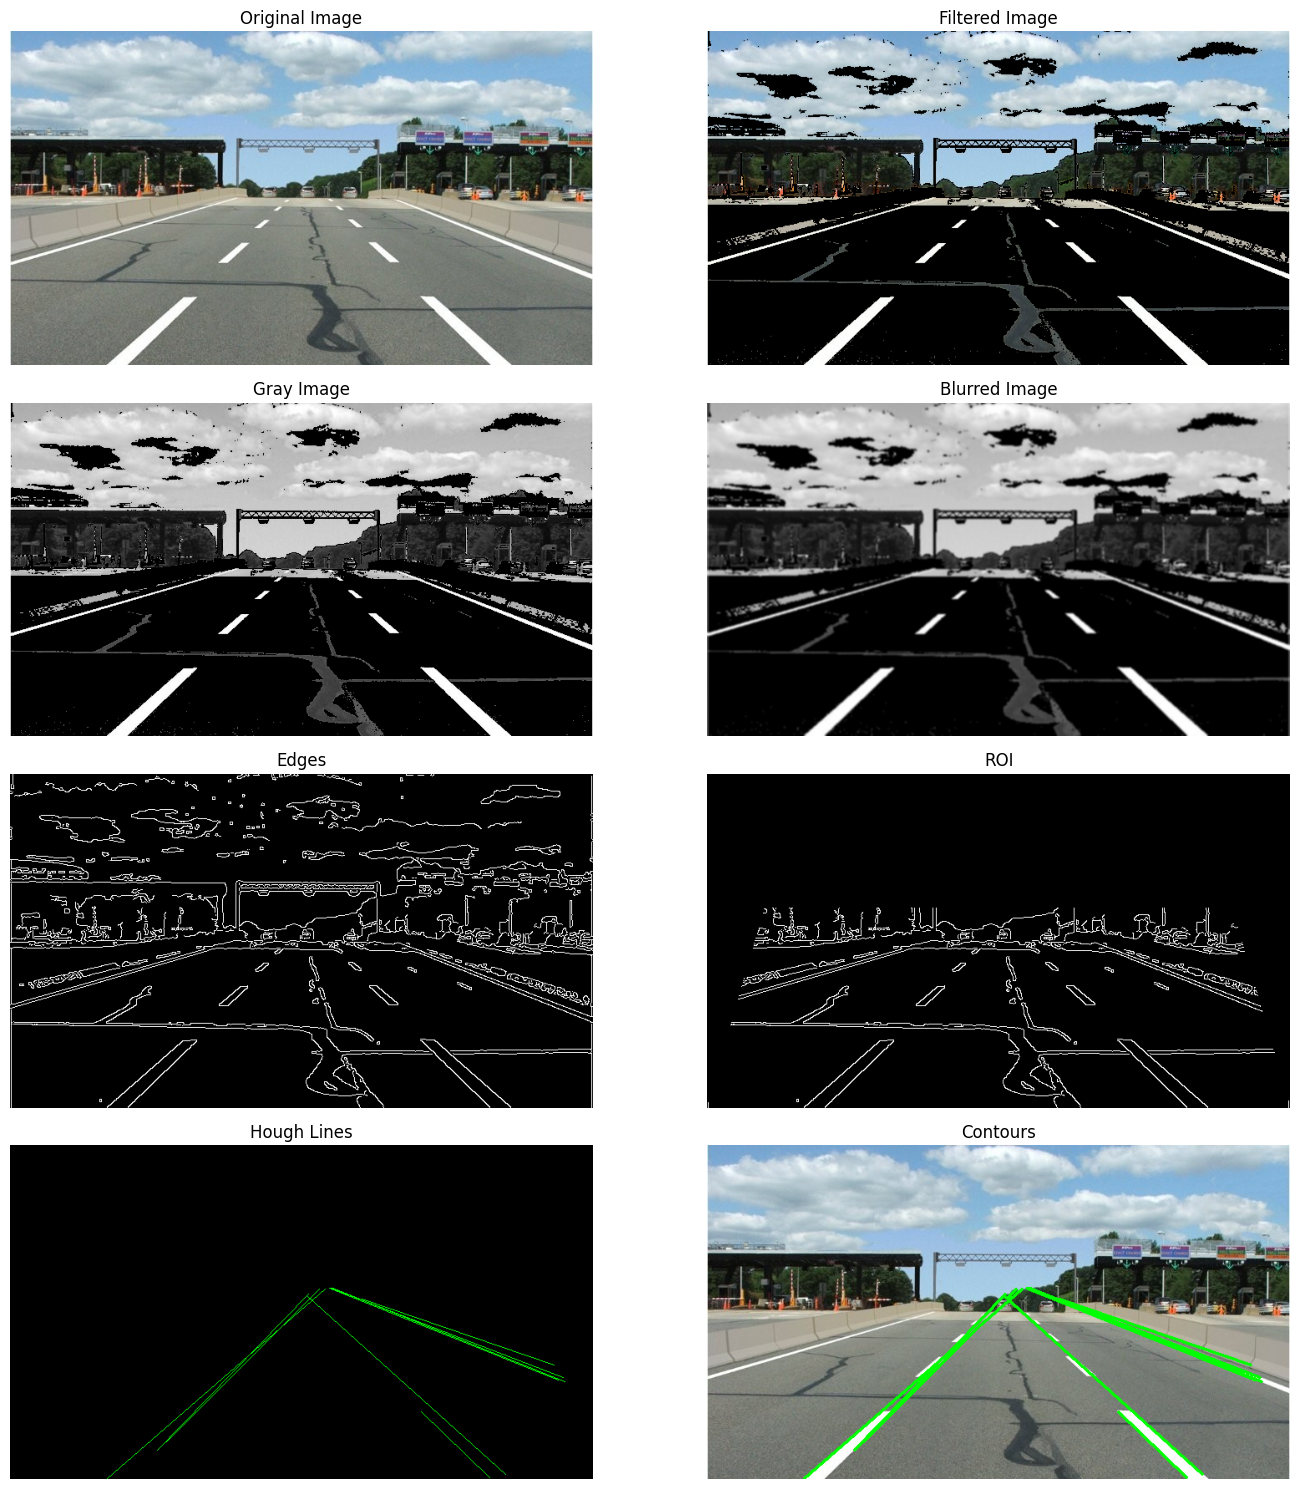

In [31]:
find_image_lane("Test Images/image2.jpeg")

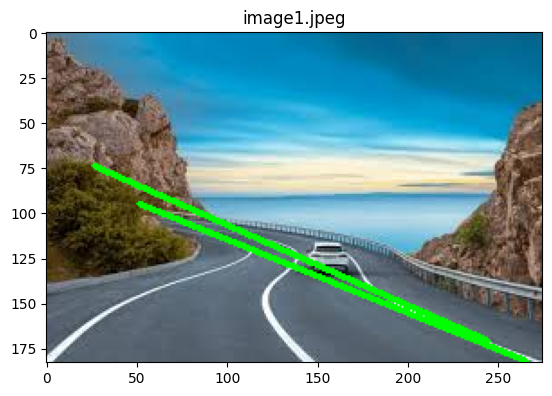

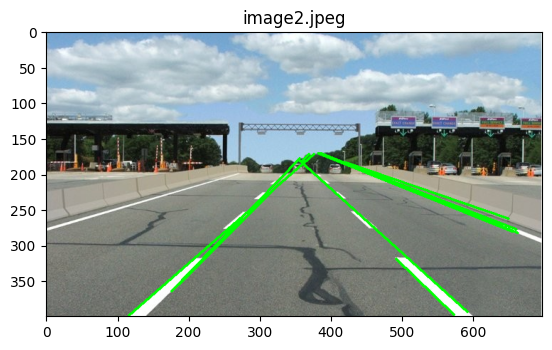

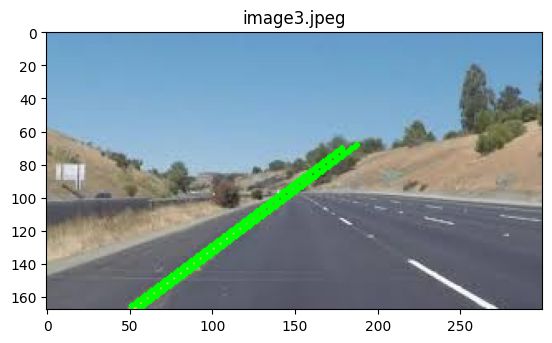

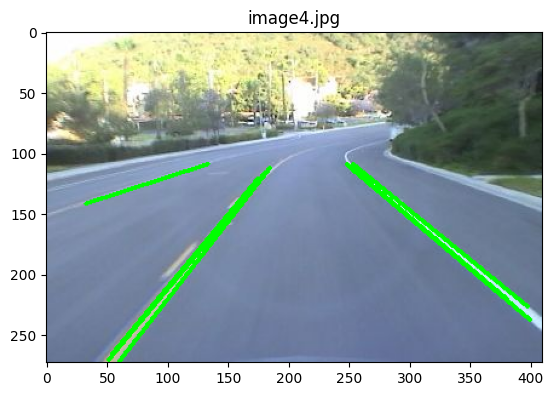

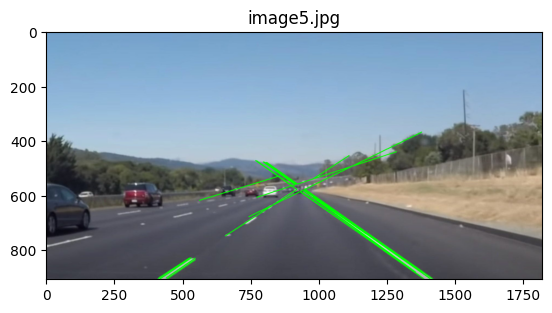

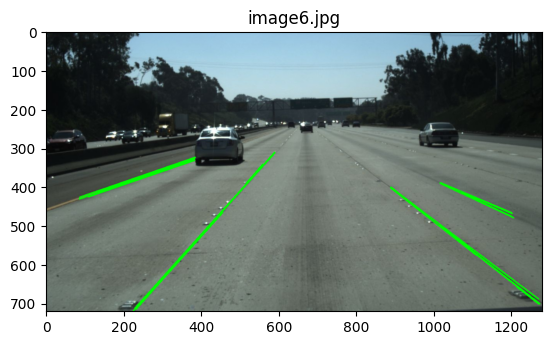

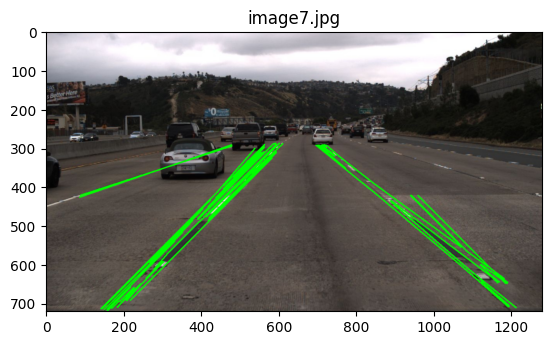

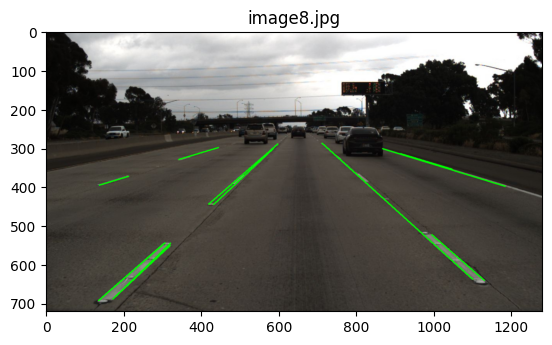

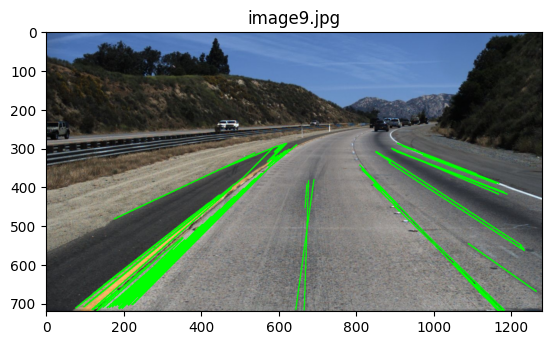

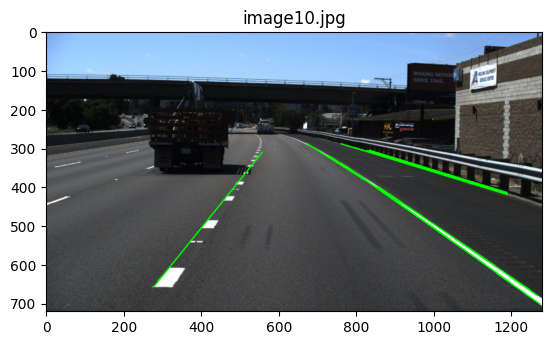

In [17]:
detect_image_lanes()